## TP 5 

In [59]:
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize
from statistics import mean
import nltk
import pandas as pd
from nltk import Nonterminal, Production
from nltk.corpus import treebank
from nltk import induce_pcfg
from nltk.parse import ViterbiParser
from collections import Counter
import time
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def install_treebank():
    import nltk
    nltk.download('treebank')

install_treebank()

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\kacem\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [3]:
CoLa_train_file = 'CoLA_data/train.tsv'
Cola_dev_file = 'CoLA_data/dev.tsv'
Cola_test_file = 'CoLA_data/test.tsv'

In [4]:
all_data = treebank.fileids()
train_data = treebank.fileids()[:180]
test_data = treebank.fileids()[180:]

## Question 3

In [218]:
# Question 3 : train a PCFG grammar using the phrase trees from the PTB corpus

def filter_rules(productions, threshold=0, top_n=None):  # On garde les repetitions + l'ordre
    
    #productions_filtered = [x for x in productions if productions.count(x) > threshold] # rules that appear > threshold time
    if threshold==0 and top_n is None:
        print("Choose a filter criteria: give a value to threshold or top_n")
        print("WARNING: did not filter anything, returning the same productions...")
        return productions
    elif threshold > 0:
        print(f"start filtering by 'threshold' .. only keeping productions that appear >  {threshold}")
        df = pd.DataFrame(productions, columns=['rule'])
        df2 = df[df['rule'].map(df['rule'].value_counts()) > threshold]
        productions_filtered = list(df2['rule'])
    elif not top_n is None:
        print(f"start filtering by 'top_n' .. only keeping the top {top_n} most frequent productions ")
        top_p = set(p[0] for p in Counter(productions).most_common(top_n))
        productions_filtered = [p for p in productions if p in top_p]
    print(f'*** productions after filtering: {len(productions_filtered)}')
    return productions_filtered

def train_PCFG_grammar_using_PTB(train_data=treebank.fileids(),filter_threshold=0, filter_top_n=None, unk=True, chomsky=False):
    # extract productions from treebank phrase trees and induce the PCFG grammar
    print("Induce PCFG grammar from treebank data:")

    productions = []
    for item in train_data:
        for tree in treebank.parsed_sents(item):
            # perform optional tree transformations, e.g.:
            if chomsky:
                tree.collapse_unary(collapsePOS=False)  # Remove branches A-B-C into A-B+C
                tree.chomsky_normal_form(horzMarkov=2)  # Remove A->(B,C,D) into A->B,C+D->D
            productions += tree.productions()

    print(f'*** productions before filtering: {len(productions)}')
    # 211968
    # print(productions)

    # FILTER THE GRAMMAR
    if filter_threshold or filter_top_n:
        # filter the grammar, before learning the probabilities
        productions = filter_rules(productions, filter_threshold, filter_top_n)

    if unk:
        # Handle UNK words 1/2
        # pour tout non terminal A intervenant dans une regle lexicale (e.g. A -> the) , ajouter des regles A -> UNK
        non_terminals_in_lexical_rules = set()  # set does not allow duplicates
        for p in productions:
            if p.is_lexical() and isinstance(p.lhs(), Nonterminal):
                non_terminals_in_lexical_rules.add(p.lhs())

        for t in non_terminals_in_lexical_rules:
            new_rule = Production(t, ['UNK'])  # create a new rule
            productions.append(new_rule)

        print(f'*** productions after handling UNK words: {len(productions)}')
        # 212014 (filtrage) regles

    # induce the grammar
    S = Nonterminal('S')
    grammar = induce_pcfg(S, productions)  # different from the one in the doc
    print(f"*** grammar productions {len(grammar.productions())}")

    return grammar


In [214]:
# no filtering
grammar = train_PCFG_grammar_using_PTB(train_data=all_data,filter_threshold=0,filter_top_n=None,unk=True,chomsky=False) 
print(grammar)

Induce PCFG grammar from treebank data:
*** productions before filtering: 179360
*** productions after handling UNK words: 179406
*** grammar productions 21809
Grammar with 21809 productions (start state = S)
    S -> NP-SBJ VP . [0.162428]
    NP-SBJ -> NP , ADJP , [0.000392567]
    NP -> NNP NNP [0.0309391]
    NNP -> 'Pierre' [0.000106259]
    NNP -> 'Vinken' [0.000212517]
    , -> ',' [0.999591]
    ADJP -> NP JJ [0.014556]
    NP -> CD NNS [0.0110015]
    CD -> '61' [0.00140964]
    NNS -> 'years' [0.0190146]
    JJ -> 'old' [0.00411311]
    VP -> MD VP [0.0523088]
    MD -> 'will' [0.301724]
    VP -> VB NP PP-CLR NP-TMP [0.000137836]
    VB -> 'join' [0.00156556]
    NP -> DT NN [0.0851458]
    DT -> 'the' [0.494489]
    NN -> 'board' [0.00227842]
    PP-CLR -> IN NP [0.679445]
    IN -> 'as' [0.0337797]
    NP -> DT JJ NN [0.031192]
    DT -> 'a' [0.229488]
    JJ -> 'nonexecutive' [0.000856898]
    NN -> 'director' [0.00243032]
    NP-TMP -> NNP CD [0.0437158]
    NNP -> 'Nov.

In [219]:
# filtering > 5
grammar = train_PCFG_grammar_using_PTB(train_data=all_data,filter_threshold=5,filter_top_n=None,unk=True,chomsky=False) 
print(grammar)

Induce PCFG grammar from treebank data:
*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  5
*** productions after filtering: 149749
*** productions after handling UNK words: 149791
*** grammar productions 3038
Grammar with 3038 productions (start state = S)
    S -> NP-SBJ VP . [0.181736]
    NP -> NNP NNP [0.0336435]
    , -> ',' [0.999795]
    ADJP -> NP JJ [0.0179856]
    NP -> CD NNS [0.0119631]
    NNS -> 'years' [0.0290624]
    JJ -> 'old' [0.00686499]
    VP -> MD VP [0.0643438]
    MD -> 'will' [0.305011]
    NP -> DT NN [0.0925883]
    DT -> 'the' [0.495764]
    NN -> 'board' [0.00319693]
    PP-CLR -> IN NP [0.715021]
    IN -> 'as' [0.0341433]
    NP -> DT JJ NN [0.0339185]
    DT -> 'a' [0.23008]
    NN -> 'director' [0.00341006]
    NP-TMP -> NNP CD [0.0529801]
    NNP -> 'Nov.' [0.0040007]
    . -> '.' [0.987871]
    NP-SBJ -> NNP NNP [0.0504594]
    NNP -> 'Mr.' [0.0652287]
    VP -> VBZ NP-PRD [0.0138182]


In [221]:
def save_grammar(name, grammar):
    # save the grammar:
    print('saving the grammar')
    with open(name+".pcfg", mode="w", encoding='utf8') as grammar_file:
        grammar_file.write('\n')
        for i in range(len(grammar.productions())):
            grammar_file.write(str(grammar.productions()[i]))
            grammar_file.write('\n')
    grammar_file.close()


save_grammar('grammar', grammar)
#print(grammar)

saving the grammar


## Question 4

In [187]:
def cola_sentences(file,wrong_only=True):
    # Reads the file and returns a list of grammatically wrong sentences, those marked with a star
    sentences = []

    with open(file, 'r', encoding="utf8") as f:
        for line in f.readlines():
            if wrong_only:
                if line.split('\t')[1] == '0':
                    sentences.append(line.rstrip().split('\t')[3])
                    #yield line.rstrip().split('\t')[3]
            else:
                sentences.append(line.rstrip().split('\t')[3])
                #yield line.rstrip().split('\t')[3]
    f.close()
    print(f'Cola dev set has {len(sentences)} {"wrong" if wrong_only else "total"} sentences')
    return sentences

In [222]:
a = cola_sentences(Cola_dev_file,wrong_only=True)
#print(len(a))
for i,x in enumerate(a):  print(i+1,x)

Cola dev set has 322 wrong sentences
1 As you eat the most, you want the least.
2 The more you would want, the less you would eat.
3 I demand that the more John eat, the more he pays.
4 The more does Bill smoke, the more Susan hates him.
5 Who does John visit Sally because he likes?
6 Mickey looked up it.
7 The box contained the ball from the tree.
8 The tube was escaped by gas.
9 What the water did to the bottle was fill it.
10 What the water did to the whole bottle was fill it.
11 Mary beautifully plays the violin.
12 Sue gave to Bill a book.
13 They represented seriously to the dean Mary as a genuine linguist.
14 Us love they.
15 Mary intended John to go abroad.
16 We wanted to invite someone, but we couldn't decide who to.
17 Mary came to be introduced by the bartender and I also came to be.
18 I know which book José didn't read for class, and which book Lilly did it for him.
19 This is the book which Bob reviewed, and this is the one which Fred won't do it.
20 I know which book Ma

In [326]:
# Question 4 : use the grammar to parse grammatically wrong sentences from Cola using ViterbiParser
def missing_words(sentence,grammar):
    nb_unk = 0
    for index, token in enumerate(sentence):
        try:
            grammar.check_coverage([token])  # takes a list !!
        except:
            sentence[index] = 'UNK'
            nb_unk += 1
    return nb_unk, sentence

def parse_sentences(sentences, grammar, parser,max_words=None, verbose=1,fname='parsing-ckpt'):
    """
    params:
    sentences, grammar, parser,max_words=None, verbose=1,fname='parsing-ckpt'

    returns:
    times = [ ] # parsing time of each sentence; 
    num_parses = [ ] # number of parses per sentence; 
    lengthes = [ ]  # nb of tokens  per sentence; 
    nb_unks = [ ] # nb of unknown words in a sentence; 
    
    comments:
    number of failed parses = num_parses.count(0) 
    """
    print('Parsing sentences ')

    times = [] # parsing time of each sentence
    num_parses = [] # number of parses per sentence
    lengthes = []  # nb of tokens  per sentence
    nb_unks = [] # nb of unknown words in a sentence
    
    nb_parsed = 0
    processed = 0

    for sent in sentences:
        if verbose>0: print(sent)
        tokens = word_tokenize(sent)  # tokenize the sentence
        if max_words is None or len(tokens) < max_words:
            processed+=1
            lengthes.append(len(tokens))
            if verbose>0: print(tokens)

            # Handle UNK words 2/2
            nb_unk, tokens = missing_words(tokens,grammar)
            if verbose>0: print(f"missing words {nb_unk}/{len(tokens)}:\t->({' '.join(tokens)})")
            nb_unks.append(nb_unk)

            t = time.time()
            parses_of_a_sentence = parser.parse_all(tokens)
            times.append(time.time() - t)
            num_parses.append(len(parses_of_a_sentence))
            if len(parses_of_a_sentence):
                nb_parsed+=1

            if verbose>0: print(f"# parsed sentence: {nb_parsed}/{processed}, total nb. of sentences: {len(sentences)}")
            np.savetxt(f"csv/{fname}.csv", [times, num_parses, lengthes, nb_unks],delimiter =", ", fmt ='% s')

    print(f"Nb. parsed sentences: {nb_parsed}/{processed}, total nb. of sentences: {len(sentences)}")
    print(f"Nb. failed parses sentences: {num_parses.count(0)}/{processed}, total nb. of sentences: {len(sentences)}")
    print(f"Missing words percentage: {100*mean([nb_unk/length for nb_unk,length in zip(nb_unks,lengthes)]):.2f} %")
    print(f"Total Time: {sum(times):.2f}s")
    return times, num_parses, lengthes, nb_unks



In [318]:
wrong_sents_cola = cola_sentences(Cola_dev_file, wrong_only=True)
# show some wrong sentences
print(wrong_sents_cola[:3])
# filtering > 5, produce the same grammar as question 3
grammar = train_PCFG_grammar_using_PTB(all_data,unk=True,filter_threshold=5,filter_top_n=None,chomsky=False)
parser = ViterbiParser(grammar,trace=0) # put trace>0 for a verbose output

Cola dev set has 322 wrong sentences
['As you eat the most, you want the least.', 'The more you would want, the less you would eat.', 'I demand that the more John eat, the more he pays.']
Induce PCFG grammar from treebank data:
*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  5
*** productions after filtering: 149749
*** productions after handling UNK words: 149791
*** grammar productions 3038


In [324]:
times, num_parses, lengthes, nb_unks = parse_sentences(wrong_sents_cola, grammar, parser, max_words=None,fname='q4-parsing')
# takes ~ 5 min

Parsing sentences 
As you eat the most, you want the least.
['As', 'you', 'eat', 'the', 'most', ',', 'you', 'want', 'the', 'least', '.']
missing words 1/11:	->(As you UNK the most , you want the least .)
# parsed sentence: 1/1, total nb. of sentences: 322
The more you would want, the less you would eat.
['The', 'more', 'you', 'would', 'want', ',', 'the', 'less', 'you', 'would', 'eat', '.']
missing words 1/12:	->(The more you would want , the less you would UNK .)
# parsed sentence: 2/2, total nb. of sentences: 322
I demand that the more John eat, the more he pays.
['I', 'demand', 'that', 'the', 'more', 'John', 'eat', ',', 'the', 'more', 'he', 'pays', '.']
missing words 2/13:	->(I demand that the more John UNK , the more he UNK .)
# parsed sentence: 3/3, total nb. of sentences: 322
The more does Bill smoke, the more Susan hates him.
['The', 'more', 'does', 'Bill', 'smoke', ',', 'the', 'more', 'Susan', 'hates', 'him', '.']
missing words 4/12:	->(The more does UNK UNK , the more UNK UNK h

### Comapraison de ViterbiParser  entre grammaire générée avec Chomsky form et sans Chomsky

In [ ]:
def accuracy(a,b):
    return sum(1 for x,y in zip(a,b) if x == y) / float(len(a))

def test(test_data,grammar,parser,max_words=15):
    accs = []
    times = []
    lengthes = []
    nb_parsed = 0
    nb_all_sent = 0
    for item in test_data:
        for tree in treebank.parsed_sents(item):
            nb_all_sent+=1
            sent = tree.leaves()
            if max_words is None or len(sent) < max_words:
                lengthes.append(len(sent))
                
                nb_unk, sent = missing_words(sent,grammar)
                print(f"missing words {nb_unk}/{len(sent)}:\t->({' '.join(sent)})")

                t = time.time() 
                parses = parser.parse_all(sent)
                end = time.time() - t
                times.append(end)
                
                if len(parses):
                    # print(tree.pos())
                    # print(parses[0].pos())
                    acc = accuracy(tree.pos(), parses[0].pos())
                    print(f"Accuracy: {acc:.2f}")
                    accs.append(acc)
                    nb_parsed+=1
    print(f"Nb. parsed sentences: {nb_parsed}/{nb_all_sent}")
    print(f"Avg. Accuracy: {mean(accs):.2f}")
    print(f"Missing words percentage: {100*mean([nb_unk/length for nb_unk,length in zip(nb_unks,lengthes)]):.2f} %")
    print(f"Total Time: {sum(times):.2f}s")
    return mean(accs)

In [208]:
# test the parser
train_data=treebank.fileids()[:180]
test_data=treebank.fileids()[180:]
grammar = train_PCFG_grammar_using_PTB(train_data,unk=True,filter_threshold=0,filter_top_n=None,chomsky=False)
parser = ViterbiParser(grammar,trace=0) # put trace>0 for a verbose output
test(test_data,grammar,parser)


Induce PCFG grammar from treebank data:
*** productions before filtering: 168412
*** productions after handling UNK words: 168458
*** grammar productions 21038
missing words 0/6:	(Terms, were, n't, disclosed, *-1, .)
Accuracy: 1.00
missing words 0/11:	(These, imports, totaled, about, $, 17, million, *U*, last, year, .)
Accuracy: 1.00
missing words 1/9:	(UNK, Inc, ., -LRB-, Chandler, ,, Ariz., -RRB-, --)
Accuracy: 0.89
missing words 0/7:	(He, increases, the, board, to, seven, .)
Accuracy: 1.00
missing words 3/9:	(UNK, did, n't, just, use, old, UNK, UNK, .)
Accuracy: 0.56
missing words 0/12:	(When, necessary, ,, it, sought, and, received, assistance, from, organized, crime, .)
Accuracy: 0.75
missing words 1/9:	(Sometimes, the, UNK, became, partners, in, the, company, .)
Accuracy: 0.89
missing words 1/7:	(UNK, management, used, the, merit, system, .)
Accuracy: 0.57
missing words 3/10:	(UNK, 's, UNK, simply, UNK, them, to, shut, up, .)
Accuracy: 0.50
missing words 1/13:	(They, take, place,

0.8220529470529471

In [209]:
# test the parser
train_data=treebank.fileids()[:180]
test_data=treebank.fileids()[180:]
grammar = train_PCFG_grammar_using_PTB(train_data,unk=True,filter_threshold=0,filter_top_n=None,chomsky=True)
parser = ViterbiParser(grammar,trace=0) # put trace>0 for a verbose output
test(test_data,grammar,parser)

Induce PCFG grammar from treebank data:
*** productions before filtering: 199024
*** productions after handling UNK words: 199070
*** grammar productions 24132
missing words 0/6:	(Terms, were, n't, disclosed, *-1, .)
Accuracy: 1.00
missing words 0/11:	(These, imports, totaled, about, $, 17, million, *U*, last, year, .)
Accuracy: 1.00
missing words 1/9:	(UNK, Inc, ., -LRB-, Chandler, ,, Ariz., -RRB-, --)
missing words 0/7:	(He, increases, the, board, to, seven, .)
Accuracy: 1.00
missing words 3/9:	(UNK, did, n't, just, use, old, UNK, UNK, .)
Accuracy: 0.56
missing words 0/12:	(When, necessary, ,, it, sought, and, received, assistance, from, organized, crime, .)
Accuracy: 0.75
missing words 1/9:	(Sometimes, the, UNK, became, partners, in, the, company, .)
Accuracy: 0.89
missing words 1/7:	(UNK, management, used, the, merit, system, .)
Accuracy: 0.57
missing words 3/10:	(UNK, 's, UNK, simply, UNK, them, to, shut, up, .)
Accuracy: 0.50
missing words 1/13:	(They, take, place, in, government

0.8197482594034318

In [163]:
times, num_parses, lengthes, nb_unks = parse_sentences(wrong_sents_cola[:3],grammar,parser)

Parsing sentences 
As you eat the most, you want the least.
['As', 'you', 'eat', 'the', 'most', ',', 'you', 'want', 'the', 'least', '.']
missing words 1/11:	(As; you; UNK; the; most; ,; you; want; the; least; .)
# parsed sentence: 1/3
The more you would want, the less you would eat.
['The', 'more', 'you', 'would', 'want', ',', 'the', 'less', 'you', 'would', 'eat', '.']
missing words 1/12:	(The; more; you; would; want; ,; the; less; you; would; UNK; .)
# parsed sentence: 2/3
I demand that the more John eat, the more he pays.
['I', 'demand', 'that', 'the', 'more', 'John', 'eat', ',', 'the', 'more', 'he', 'pays', '.']
missing words 2/13:	(I; demand; that; the; more; John; UNK; ,; the; more; he; UNK; .)
# parsed sentence: 3/3
Nb. parsed sentences: 3/3
[1, 1, 2]
[11, 12, 13]
Missing words ratio: 0.11


## Question 5

### Q 5.b

In [236]:
# # Question 5.B
# longeur moyenne Cola
from statistics import stdev
sents_cola = cola_sentences(Cola_dev_file,wrong_only=True)
sentences_lengths_cola = [len(word_tokenize(sent)) for sent in sents_cola]
average_length_cola = mean(sentences_lengths_cola) #todo: should we count punctuation '.' , ','as words ?  the leaves() does
print(f"* average_length_cola : {average_length_cola:.2f}\t-> around ~ {round(average_length_cola)} words per sentence")  # round it to have exact nb of words
print(f"* max_length_cola: {max([len(word_tokenize(sent)) for sent in sents_cola]):.2f}")
print(f"* min_length_cola: {min([len(word_tokenize(sent)) for sent in sents_cola]):.2f}")
print(f"* std_length_cola: {stdev([len(word_tokenize(sent)) for sent in sents_cola]):.2f}\n")

# longeur moyenne Treebank
sentences_lengths_PTB = []
print(f"* number of files from treebank : {len(treebank.fileids())}") # 199 file

# for item in treebank.fileids():
#     for tree in treebank.parsed_sents(item):
#         # print(tree.leaves())
#         sentences_lengths_PTB.append(len(tree.leaves()))
sentences_lengths_PTB = [len(tree.leaves()) for item in treebank.fileids() for tree in treebank.parsed_sents(item)]
print(f"* number of sentences PTB: {len(sentences_lengths_PTB)}\n") #  3914 phrases in PTB

average_length_PTB = mean(sentences_lengths_PTB)
print(f"* average_length_PTB: {average_length_PTB:.2f}\t-> around ~ {round(average_length_PTB)} words per sentence")  # round it to have exact nb of words
print(f"* max_length_PTB: {max(sentences_lengths_PTB):.2f}")
print(f"* min_length_PTB: {min(sentences_lengths_PTB):.2f}")
print(f"* std_length_PTB: {stdev(sentences_lengths_PTB):.2f}")


Cola dev set has 322 wrong sentences
* average_length_cola : 9.22	-> around ~ 9 words per sentence
* max_length_cola: 29.00
* min_length_cola: 2.00
* std_length_cola: 4.58

* number of files from treebank : 199
* number of sentences PTB: 3914

* average_length_PTB: 25.72	-> around ~ 26 words per sentence
* max_length_PTB: 271.00
* min_length_PTB: 1.00
* std_length_PTB: 12.87


In [304]:
import plotly.express as px
names= ['PTB']*len(sentences_lengths_PTB)+['CoLa']*len(sentences_lengths_cola)
lengths = sentences_lengths_PTB+sentences_lengths_cola
df = pd.DataFrame(list(zip(lengths,names)), columns=['sentences lengths','data'])
fig = px.box(df, x="data", y="sentences lengths", points="all")
fig.show()

,sentences lengths,data
0,18,PTB
1,13,PTB
2,27,PTB
3,41,PTB
4,35,PTB
...,...,...
4231,8,CoLa
4232,12,CoLa
4233,8,CoLa
4234,8,CoLa


In [90]:
# Vous pouvez obtenir les arbres de ces phrases comme suit :
#for item in treebank.fileids():
    #   for tree in treebank.parsed_sents(item):
    #      print(tree)

# see a tree
print ( treebank.parsed_sents(treebank.fileids()[0]) )
t = treebank.parsed_sents(treebank.fileids()[0])[1]
t.draw()

[Tree('S', [Tree('NP-SBJ', [Tree('NP', [Tree('NNP', ['Pierre']), Tree('NNP', ['Vinken'])]), Tree(',', [',']), Tree('ADJP', [Tree('NP', [Tree('CD', ['61']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])]), Tree(',', [','])]), Tree('VP', [Tree('MD', ['will']), Tree('VP', [Tree('VB', ['join']), Tree('NP', [Tree('DT', ['the']), Tree('NN', ['board'])]), Tree('PP-CLR', [Tree('IN', ['as']), Tree('NP', [Tree('DT', ['a']), Tree('JJ', ['nonexecutive']), Tree('NN', ['director'])])]), Tree('NP-TMP', [Tree('NNP', ['Nov.']), Tree('CD', ['29'])])])]), Tree('.', ['.'])]), Tree('S', [Tree('NP-SBJ', [Tree('NNP', ['Mr.']), Tree('NNP', ['Vinken'])]), Tree('VP', [Tree('VBZ', ['is']), Tree('NP-PRD', [Tree('NP', [Tree('NN', ['chairman'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('NP', [Tree('NNP', ['Elsevier']), Tree('NNP', ['N.V.'])]), Tree(',', [',']), Tree('NP', [Tree('DT', ['the']), Tree('NNP', ['Dutch']), Tree('VBG', ['publishing']), Tree('NN', ['group'])])])])])]), Tree('.', ['.'])])]


### Q 5.c

In [327]:
# Question 5.C Analyse
nb_of_cola_phrases = 50
sents_cola = cola_sentences(Cola_dev_file,wrong_only=False)

print(f'***Analyse sur une partie seulement {nb_of_cola_phrases} des phrases du dev de CoLA.')

print('Studying filtrage impact..')
# all_times_filtered_sorted = [] #list of lists
# all_lengths_filtered_sorted = []
all_times_filtered= [] #list of lists
all_num_parses_filtered = [] #list of lists
all_lengths_filtered = []
num_failed_parses = []
nb_rules_after_filtrage = []

seuil_filtrage = [0, 1, 3, 5, 7, 10, 20, 50]  #TODO: add more filtrage later, maybe bigger order, 20, 100 ?

for i in seuil_filtrage:
    name = 'grammar_filtered_seuil_' + str(i) if i else 'grammar_not_filtered'
    grammar_filtered = train_PCFG_grammar_using_PTB(all_data,unk=True,filter_threshold=i,filter_top_n=None)
    parser = ViterbiParser(grammar_filtered)

    save_grammar(name, grammar_filtered)
    nb_rules_after_filtrage.append(len(grammar_filtered.productions()))

    times_filtered, num_parses_filtered, lengths_filtered, nb_unks_filtered = parse_sentences(sents_cola[:nb_of_cola_phrases],
                                                                            grammar_filtered, parser,verbose=0,fname=name+'-ckpt')
    #assert lengths == lengths_filtered # why assert ?
    
    all_times_filtered.append(times_filtered) 
    all_lengths_filtered.append(lengths_filtered) 
    # no need to sort 
    # lengths_filtered_sorted, times_filtered_sorted = zip(*sorted(zip(lengths_filtered, times_filtered)))
    # all_times_filtered_sorted.append(list(times_filtered_sorted))
    # all_lengths_filtered_sorted.append(list(lengths_filtered_sorted))
    #assert lengthes_sorted == lengthes_filtered_sorted # why assert ?

    nb_failed_parses = num_parses_filtered.count(0)
    num_failed_parses.append(nb_failed_parses)
    print(f'nb of pharses non_reconnus :{nb_failed_parses}')

    all_num_parses_filtered.append(num_parses_filtered)
    
    np.savetxt(f"csv/{name}.csv", [times_filtered, num_parses_filtered, lengths_filtered, nb_unks_filtered],delimiter =", ", fmt ='% s')
    np.savetxt(f"csv/grammar_filtered_all.csv", [nb_rules_after_filtrage, all_times_filtered, all_lengths_filtered, num_failed_parses],delimiter =", ", fmt ='% s')
    # np.savetxt(f"csv/grammar_filtered_all_sorted.csv", [nb_rules_after_filtrage, all_times_filtered_sorted, all_lengths_filtered_sorted, num_failed_parses],delimiter =", ", fmt ='% s')

print('Done Analyse')

# this takes 16m 0.5s

Cola dev set has 1043 total sentences
***Analyse sur une partie seulement 50 des phrases du dev de CoLA.
Studying filtrage impact..
Induce PCFG grammar from treebank data:
*** productions before filtering: 179360
*** productions after handling UNK words: 179406
*** grammar productions 21809
saving the grammar
Parsing sentences 
Nb. parsed sentences: 49/50, total nb. of sentences: 50
Nb. failed parses sentences: 1/50, total nb. of sentences: 50
Missing words percentage: 11.51 %
Total Time: 615.12s
nb of pharses non_reconnus :1
Induce PCFG grammar from treebank data:


C:\Users\kacem\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  1
*** productions after filtering: 166596
*** productions after handling UNK words: 166639
*** grammar productions 9042
saving the grammar
Parsing sentences 
Nb. parsed sentences: 48/50, total nb. of sentences: 50
Nb. failed parses sentences: 2/50, total nb. of sentences: 50
Missing words percentage: 16.84 %
Total Time: 188.61s
nb of pharses non_reconnus :2
Induce PCFG grammar from treebank data:


C:\Users\kacem\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  3
*** productions after filtering: 156047
*** productions after handling UNK words: 156089
*** grammar productions 4469
saving the grammar
Parsing sentences 
Nb. parsed sentences: 45/50, total nb. of sentences: 50
Nb. failed parses sentences: 5/50, total nb. of sentences: 50
Missing words percentage: 22.84 %
Total Time: 74.03s
nb of pharses non_reconnus :5
Induce PCFG grammar from treebank data:


C:\Users\kacem\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  5
*** productions after filtering: 149749
*** productions after handling UNK words: 149791
*** grammar productions 3038
saving the grammar
Parsing sentences 
Nb. parsed sentences: 45/50, total nb. of sentences: 50
Nb. failed parses sentences: 5/50, total nb. of sentences: 50
Missing words percentage: 25.51 %
Total Time: 36.19s
nb of pharses non_reconnus :5
Induce PCFG grammar from treebank data:


C:\Users\kacem\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  7
*** productions after filtering: 145222
*** productions after handling UNK words: 145264
*** grammar productions 2332
saving the grammar
Parsing sentences 
Nb. parsed sentences: 45/50, total nb. of sentences: 50
Nb. failed parses sentences: 5/50, total nb. of sentences: 50
Missing words percentage: 29.00 %
Total Time: 28.98s
nb of pharses non_reconnus :5
Induce PCFG grammar from treebank data:


C:\Users\kacem\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  10
*** productions after filtering: 139991
*** productions after handling UNK words: 140033
*** grammar productions 1744
saving the grammar
Parsing sentences 
Nb. parsed sentences: 45/50, total nb. of sentences: 50
Nb. failed parses sentences: 5/50, total nb. of sentences: 50
Missing words percentage: 30.89 %
Total Time: 22.03s
nb of pharses non_reconnus :5
Induce PCFG grammar from treebank data:


C:\Users\kacem\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  20
*** productions after filtering: 128407
*** productions after handling UNK words: 128445
*** grammar productions 939
saving the grammar
Parsing sentences 
Nb. parsed sentences: 40/50, total nb. of sentences: 50
Nb. failed parses sentences: 10/50, total nb. of sentences: 50
Missing words percentage: 40.40 %
Total Time: 11.94s
nb of pharses non_reconnus :10
Induce PCFG grammar from treebank data:


C:\Users\kacem\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



*** productions before filtering: 179360
start filtering by 'threshold' .. only keeping productions that appear >  50
*** productions after filtering: 112358
*** productions after handling UNK words: 112393
*** grammar productions 421
saving the grammar
Parsing sentences 
Nb. parsed sentences: 34/50, total nb. of sentences: 50
Nb. failed parses sentences: 16/50, total nb. of sentences: 50
Missing words percentage: 48.77 %
Total Time: 5.37s
nb of pharses non_reconnus :16
Done Analyse


C:\Users\kacem\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


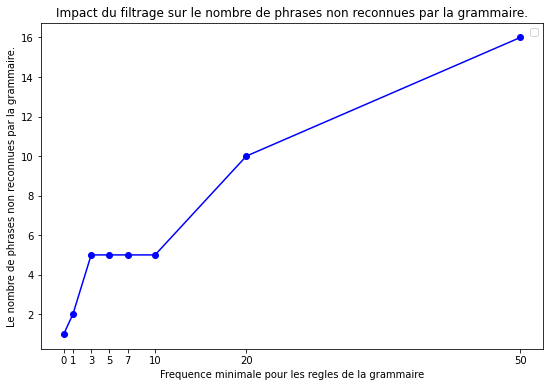

In [392]:
##TODO plot from csv files just in case

# first plot : nb of failed parses in fonction of seuil de filtrage
def plot_num_failed_parses_per_filter(seuil_filtrage, num_failed_parses,fname="courbe-failed_parses"):
    plt.figure(figsize=(9,6))
    plt.plot(seuil_filtrage, num_failed_parses, 'bo-')
    plt.title('Impact du filtrage sur le nombre de phrases non reconnues par la grammaire.')
    plt.xlabel('Frequence minimale pour les regles de la grammaire')
    plt.ylabel('Le nombre de phrases non reconnues par la grammaire.')
    plt.xticks(seuil_filtrage)
    plt.legend(loc='best')
    plt.savefig(f"plots/{fname}.svg", format="svg")
    plt.savefig(f"plots/{fname}.png", format="png")
    plt.savefig(f"plots/{fname}.eps", format="eps")
    plt.show()

plot_num_failed_parses_per_filter(seuil_filtrage, num_failed_parses,fname="c-courbe-failed_parses")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


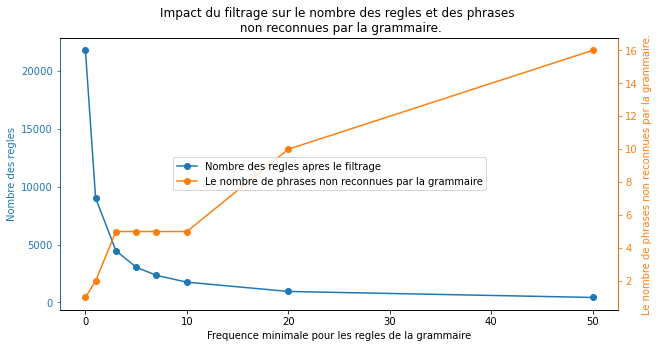

In [393]:
# second plot : nb of failed parses + nb of remaninig rules in fonction of seuil de filtrage #todo: check this picture
def plot_nb_failed_parses_and_nb_rules_per_filter(num_failed_parses, nb_rules_after_filtrage,seuil_filtrage,fname="courbe-failed_parses-nb_rules"):
    fig, ax1 = plt.subplots(figsize=(10, 5),facecolor='w')

    ax1.plot(seuil_filtrage, nb_rules_after_filtrage, 'o-')
    ax1.set_ylabel('Nombre des regles', color='C0')
    ax1.tick_params(axis='y', colors='C0')
    ax1.set_xlabel("Frequence minimale pour les regles de la grammaire")

    ax1.set_title('Impact du filtrage sur le nombre des regles et des phrases \n non reconnues par la grammaire.')

    ax2 = ax1.twinx()
    ax2.plot(seuil_filtrage, num_failed_parses, 'C1o-')
    ax2.set_ylabel('Le nombre de phrases non reconnues par la grammaire.', color='C1')
    ax2.tick_params(axis='y', colors='C1')
    ax2.spines['right'].set_color('C1')
    ax2.spines['left'].set_color('C0')

    # plt.xticks(seuil_filtrage)

    fig.legend(['Nombre des regles apres le filtrage', 'Le nombre de phrases non reconnues par la grammaire'], loc='center')
    plt.savefig(f"plots/{fname}.svg", format="svg")
    plt.savefig(f"plots/{fname}.png", format="png")
    plt.savefig(f"plots/{fname}.eps", format="eps")

    plt.show()

plot_nb_failed_parses_and_nb_rules_per_filter(
    num_failed_parses, nb_rules_after_filtrage, seuil_filtrage,
    fname="c-courbe-failed_parses-nb_rules")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


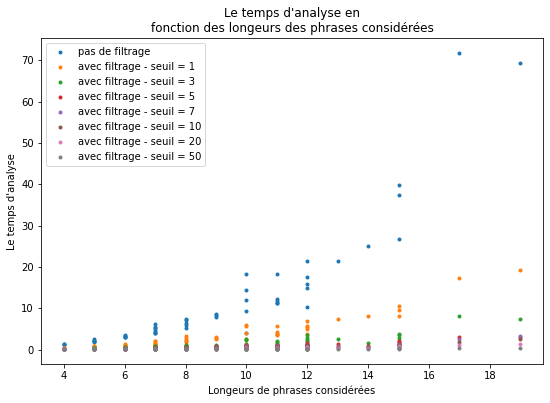

In [394]:
#third plot : parsing times in foction of length of the phrases + filtering impact
def plot_time_per_sentence_length(all_lengths_filtered, all_times_filtered,fname="courbe-time-length"):
    plt.figure(figsize=(9,6))
    for i in range(len(seuil_filtrage)):
        label =  f"avec filtrage - seuil = {seuil_filtrage[i]}" if i else "pas de filtrage"
        plt.plot(all_lengths_filtered[i], all_times_filtered[i], '.',label=label)
    plt.title("Le temps d'analyse en\nfonction des longeurs des phrases considérées")
    plt.xlabel('Longeurs de phrases considérées')
    plt.ylabel("Le temps d'analyse")
    #plt.xlim((0,20))

    plt.legend()
    plt.savefig(f"plots/{fname}.svg", format="svg")
    plt.savefig(f"plots/{fname}.png", format="png")
    plt.savefig(f"plots/{fname}.eps", format="eps")
    plt.show()

plot_time_per_sentence_length(all_lengths_filtered, all_times_filtered,fname="c-courbe-time-length")

In [391]:
# data = {   'Longeurs de phrases considérées' : all_lengths_filtered_sorted ,
#            "Le temps d'analyse" : all_times_filtered_sorted,
#            "Filtrage" : [[f"avec filtrage - seuil = {seuil_filtrage[i]}" if i else "pas de filtrage"]*len(all_lengths_filtered_sorted[i]) for i in range(len(seuil_filtrage))] ,
#         }
longs= sum([list(x) for x in all_lengths_filtered], [])
temps = sum([list(x) for x in  all_times_filtered], [])
label = [[f"avec filtrage - seuil = {seuil_filtrage[i]}" if i else "pas de filtrage"]*len(all_lengths_filtered[i]) for i in range(len(seuil_filtrage)) ]
data = {   'Longeurs de phrases considérées' : longs ,
           "Le temps d'analyse" : temps,
           "Filtrage" : sum(label,[]),
        }
df = pd.DataFrame(data)

fig = px.scatter(df, x='Longeurs de phrases considérées', y="Le temps d'analyse", color="Filtrage", trendline="lowess")
fig.show()


### Q 5.d

In [ ]:
# Question 5.D Analyse
max_words=15
sents_cola = cola_sentences(Cola_dev_file,wrong_only=True)

print(f'***Analyse sur les phrases agrammaticales ({len(sents_cola)}) du dev de CoLA.')

print('Studying filtrage impact..')

all_times_filtered= [] #list of lists
all_num_parses_filtered = [] #list of lists
all_lengths_filtered = []
num_failed_parses = []
nb_rules_after_filtrage = []

seuil_filtrage = [0, 1, 3, 5, 7, 10, 20, 50]  

for i in seuil_filtrage:
    name = 'd-grammar_filtered_seuil_' + str(i) if i else 'd-grammar_not_filtered'
    grammar_filtered = train_PCFG_grammar_using_PTB(all_data,unk=True,filter_threshold=i,filter_top_n=None)
    parser = ViterbiParser(grammar_filtered)

    save_grammar(name, grammar_filtered)
    nb_rules_after_filtrage.append(len(grammar_filtered.productions()))

    times_filtered, num_parses_filtered, lengths_filtered, nb_unks_filtered = parse_sentences(sents_cola[:nb_of_cola_phrases],
                                                                            grammar_filtered, parser,max_words=max_words,verbose=0,fname=f"d-{name}-ckpt")
    
    all_times_filtered.append(times_filtered) 
    all_lengths_filtered.append(lengths_filtered) 

    nb_failed_parses = num_parses_filtered.count(0)
    num_failed_parses.append(nb_failed_parses)
    print(f'nb of pharses non_reconnus :{nb_failed_parses}')

    all_num_parses_filtered.append(num_parses_filtered)
    
    np.savetxt(f"csv/d-{name}.csv", [times_filtered, num_parses_filtered, lengths_filtered, nb_unks_filtered],delimiter =", ", fmt ='% s')
    np.savetxt(f"csv/d-grammar_filtered_all.csv", [nb_rules_after_filtrage, all_times_filtered, all_lengths_filtered, num_failed_parses],delimiter =", ", fmt ='% s')
    # np.savetxt(f"csv/grammar_filtered_all_sorted.csv", [nb_rules_after_filtrage, all_times_filtered_sorted, all_lengths_filtered_sorted, num_failed_parses],delimiter =", ", fmt ='% s')

print('Done Analyse')



______________________________
## Draft

In [15]:
pr = filter_rules(productions, threshold=100)
pr = filter_rules(productions, top_n=100)


start filtering by 'threshold' .. only keeping productions that appear >  100
*** productions after filtering: 117088
start filtering by 'top_n' .. only keeping the top 100 most frequent productions 
*** productions after filtering: 89707


__________________________________________________________
### End Draft